In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, Isomap
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')


In [11]:
# location = f"{IO.get_root()}/binding_0" # has sep energies
location = f"{IO.get_root()}/all_0_all_data_200k" # has sep energies
# location = f"{IO.get_root()}/all_0_all_data_20k_no_zn" # does not have seperation energies
# location = f"{IO.get_root()}/all_0_extrap_1_20k_no_zn_4depth"
args = IO.load_args(f"{location}/args.yaml")
if not hasattr(args, "PER_NUCLEON"):
    args.PER_NUCLEON = "true"
if not hasattr(args, "TRAIN_SET"):
    args.TRAIN_SET = "all"
args.DEV = "cpu"
data = prepare_nuclear_data(args)
new_model = get_model_and_optim(data, args)[0]
# new_model.load_state_dict(torch.load(f"{location}/ckpts/model-18000.pt"))
new_model.load_state_dict(torch.load(f"{location}/model.pt"))
model_name = location.strip("/").split('/')[-1]

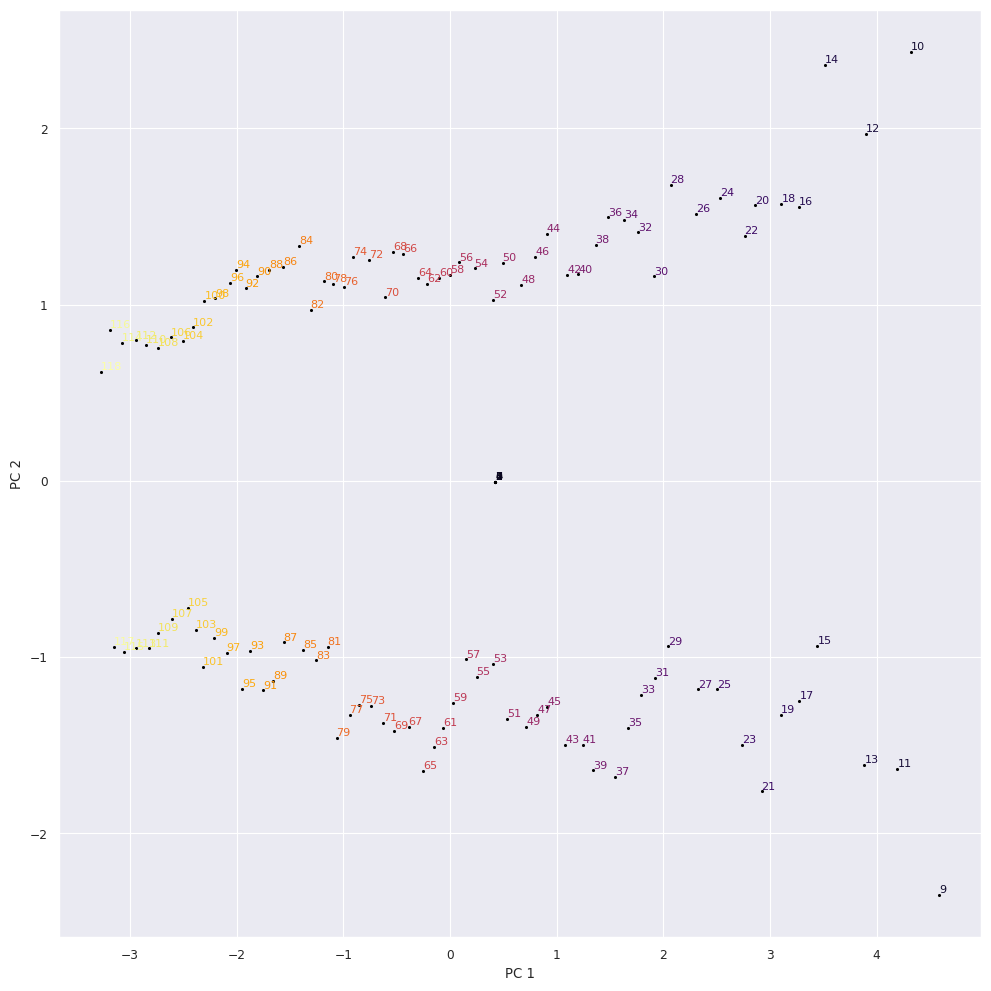

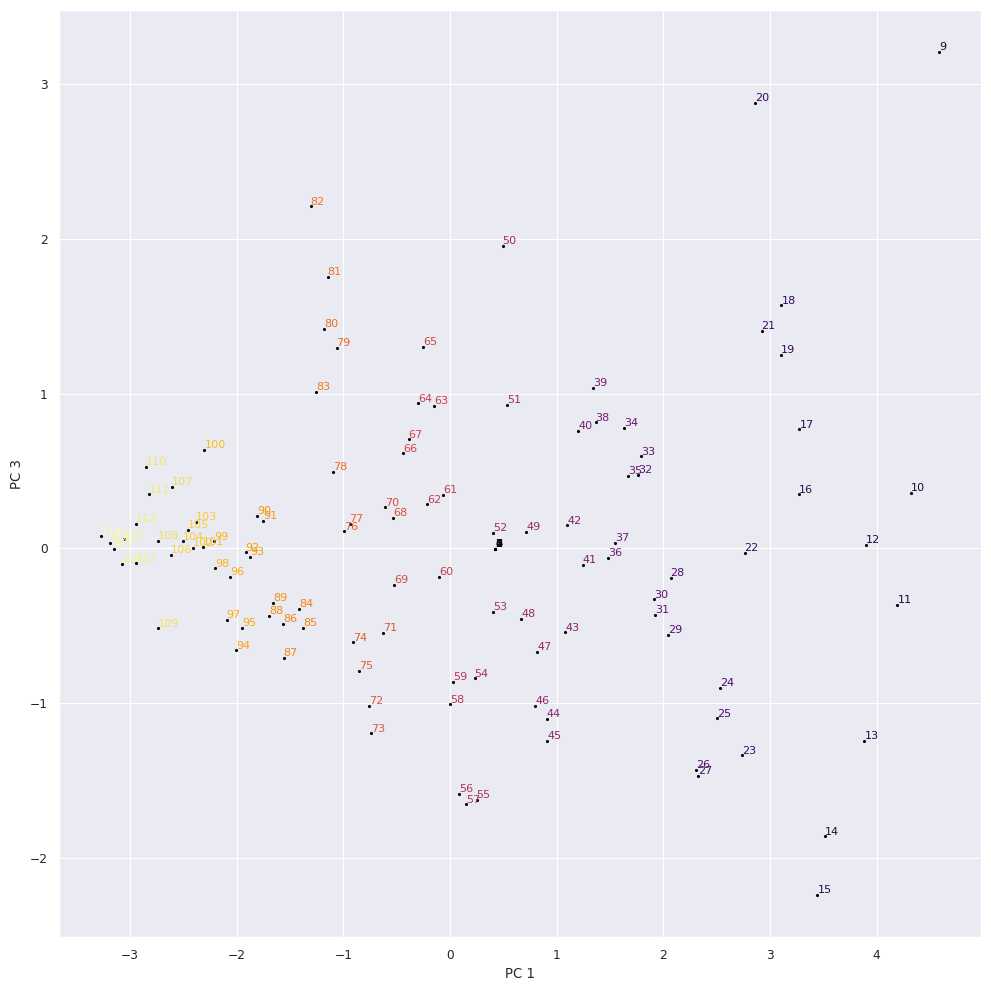

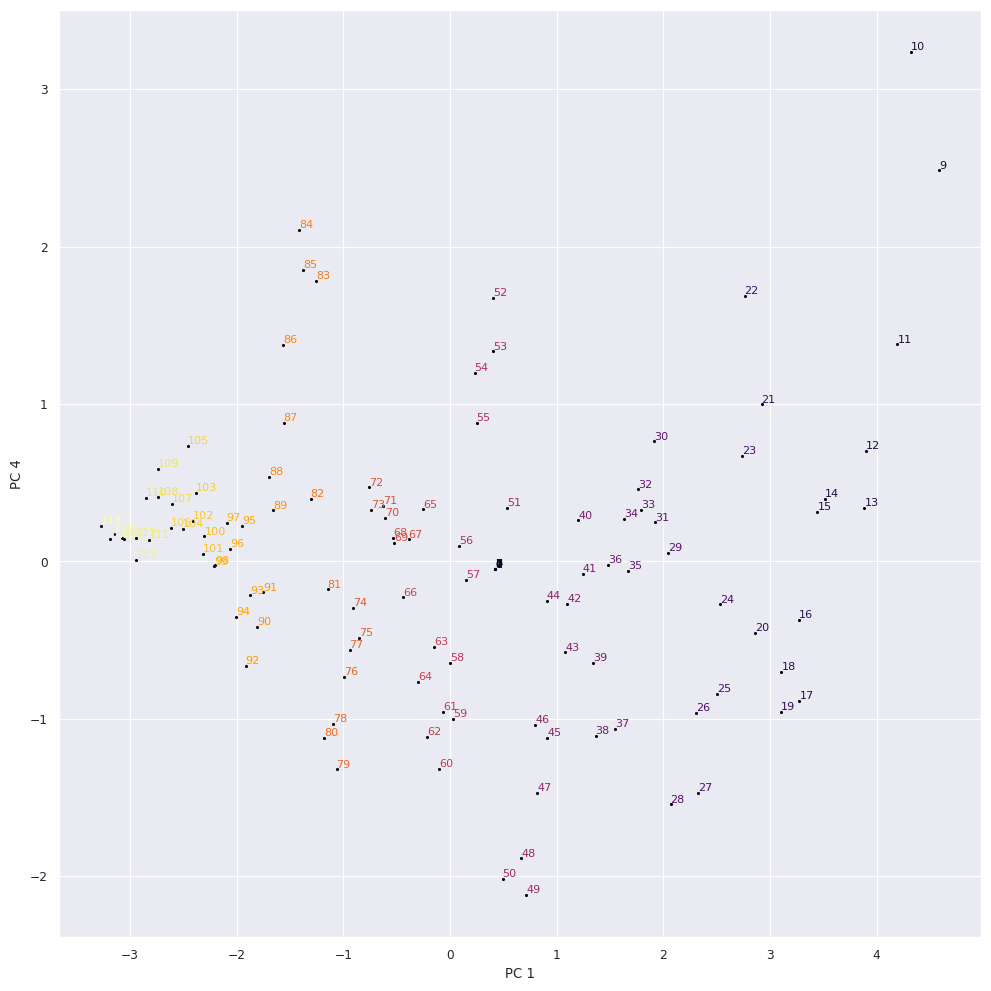

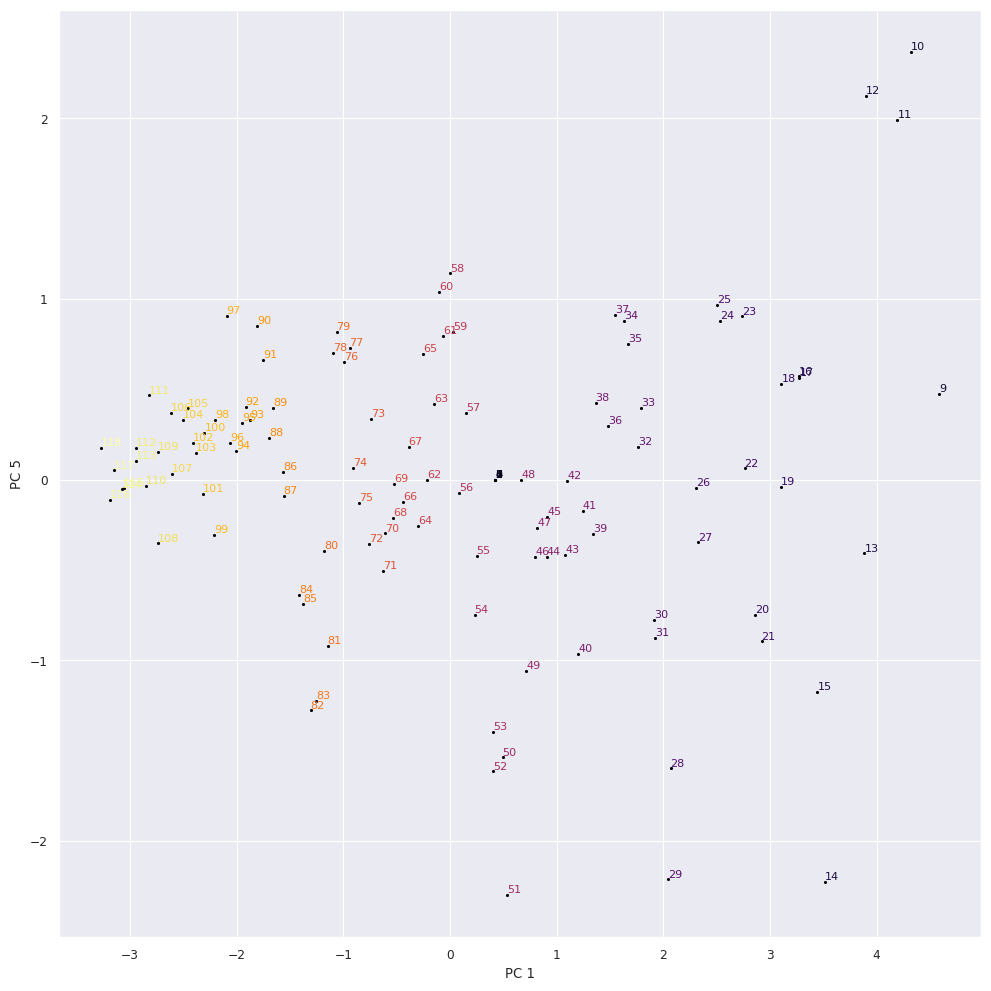

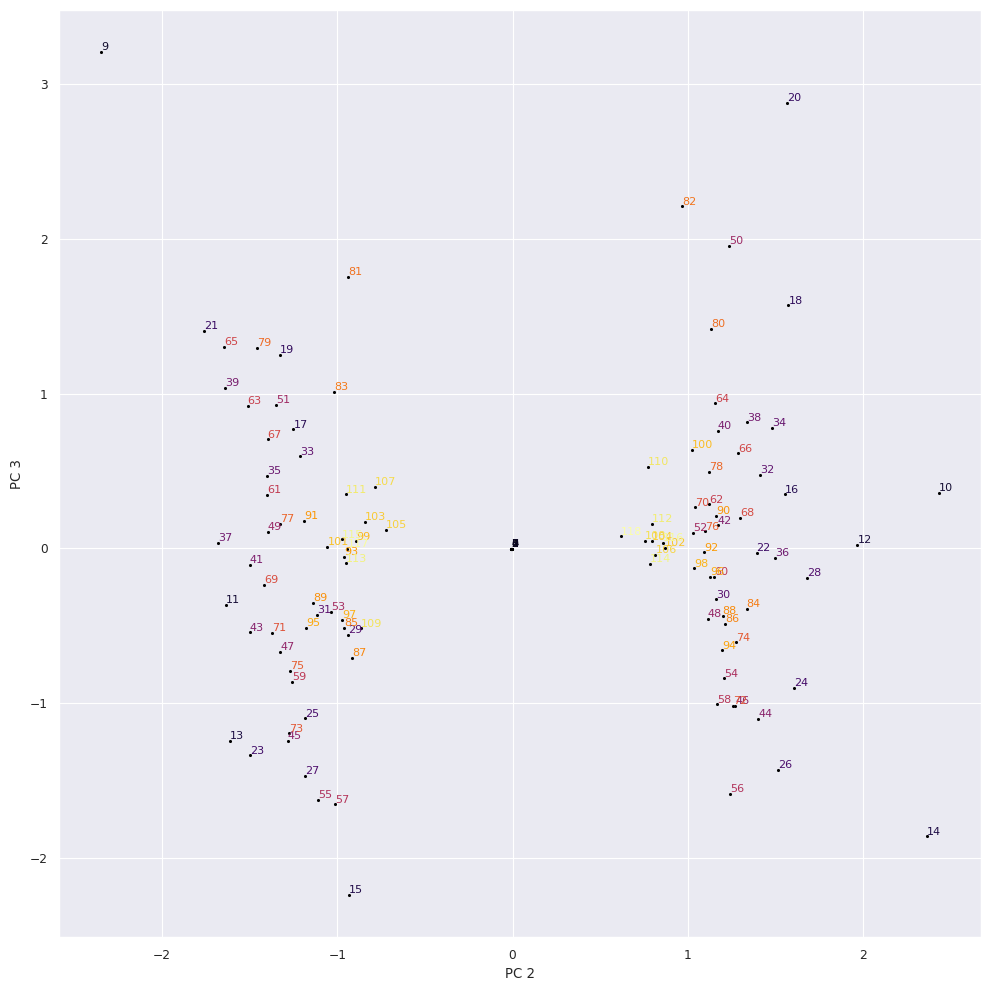

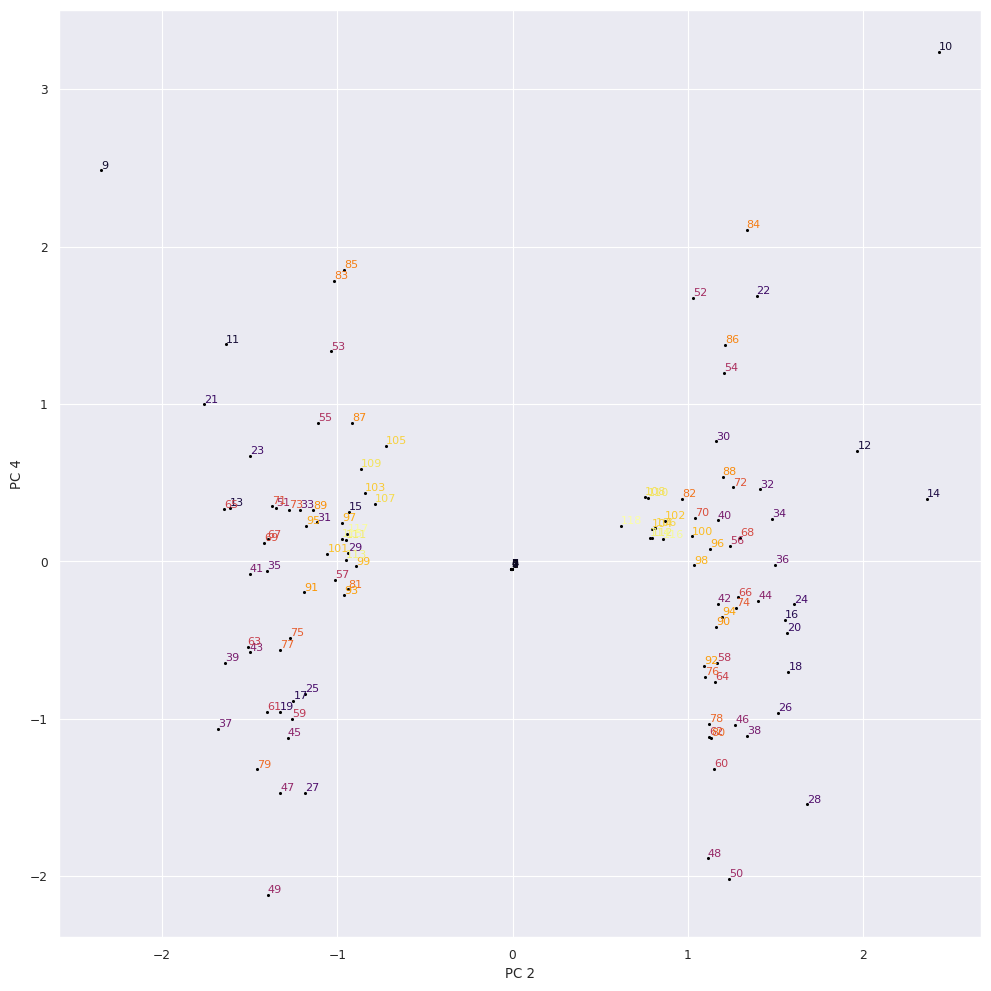

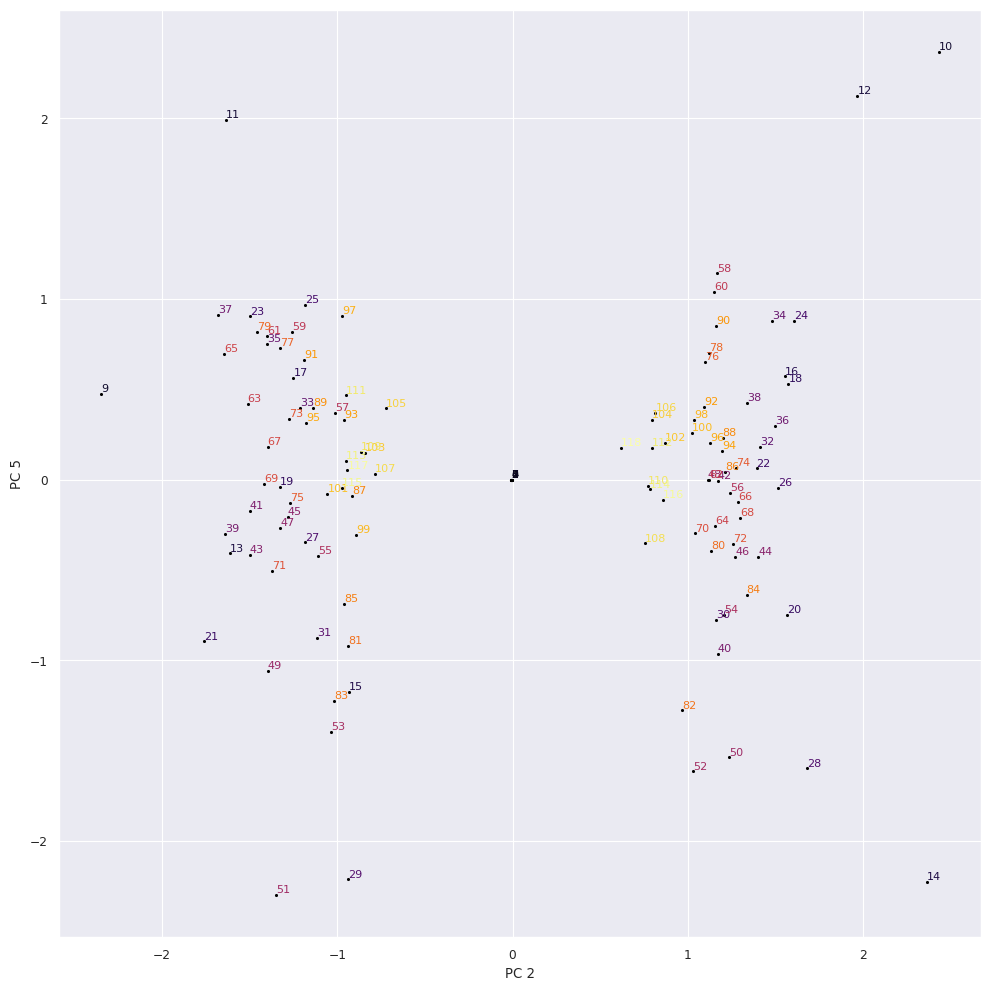

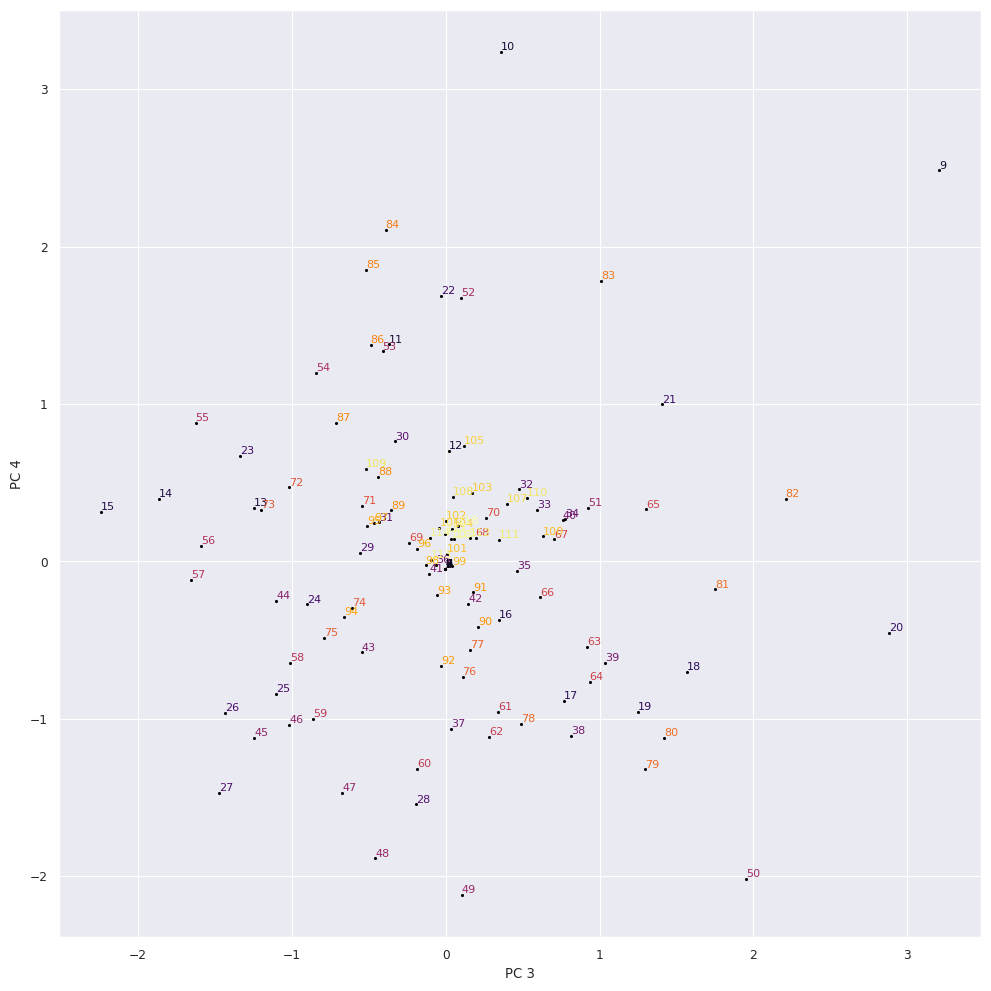

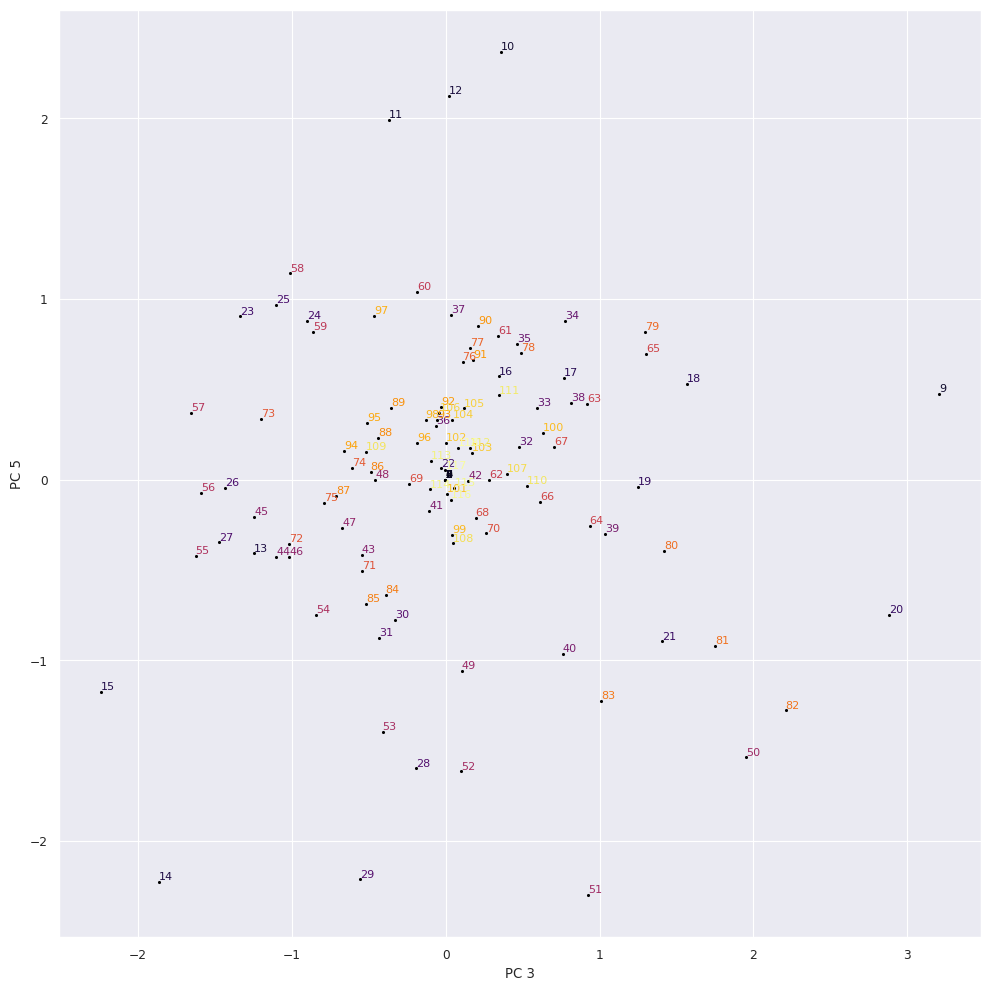

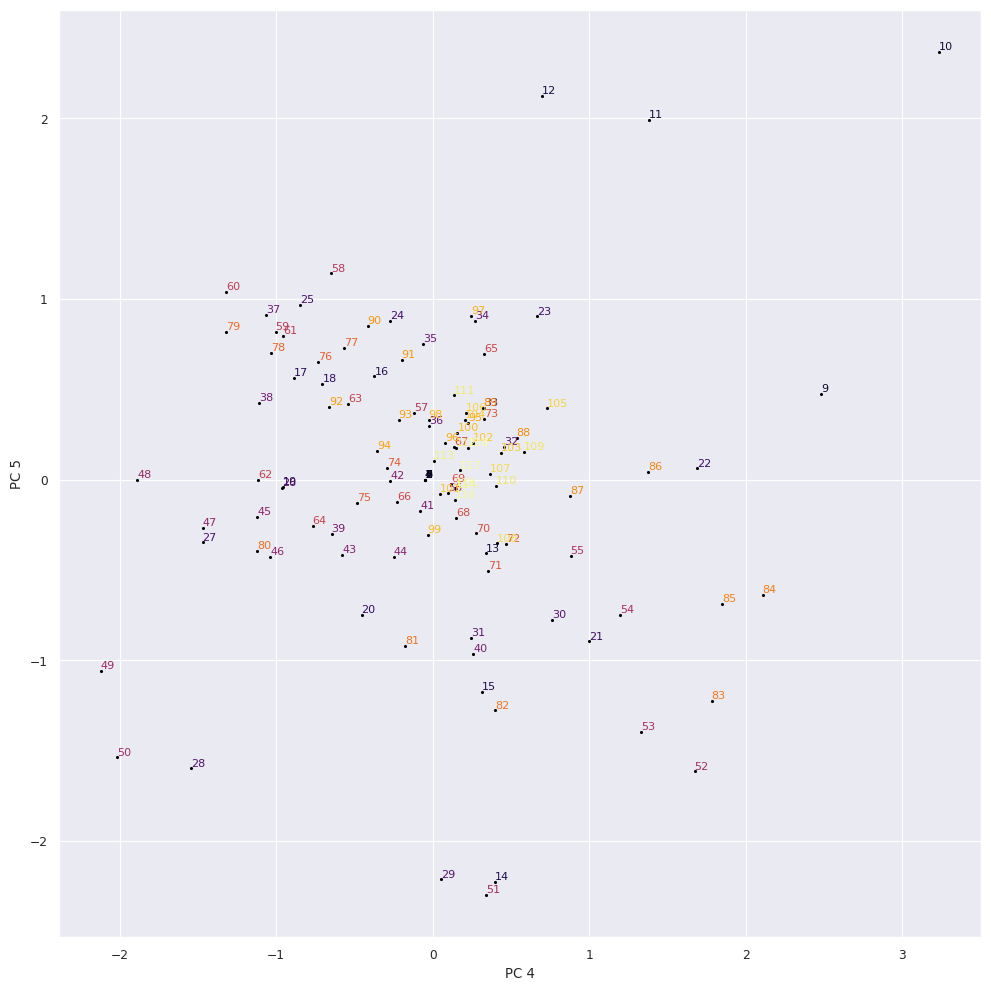

In [12]:
for i, nucleon in enumerate(["N"]):
    embed = new_model.emb[i].detach().cpu().numpy()

    pca = PCA(n_components=(n_components:=5))
    embed = pca.fit_transform(embed)
    colors = plt.cm.inferno(np.linspace(0, 1, len(embed)))

    # Create a figure for each pair of PCs
    for i in range(n_components):
        for j in range(i+1, n_components):
            fig, ax = plt.subplots(figsize=(10, 10))
            x, y = embed[:, i], embed[:, j]
            scatter = ax.scatter(x, y, s=2, c='k')
            PlottingContext.scatter_text(np.arange(len(embed)), x, y, colors=colors, ax=ax, fontsize=8)
            ax.set_xlabel(f"PC {i+1}")
            ax.set_ylabel(f"PC {j+1}")
            fig.tight_layout()
            # plt.savefig(f"plots/paper/new_{model_name}_embeddings_{nucleon}_PC{i+1}_PC{j+1}.pdf")
            plt.show()
    

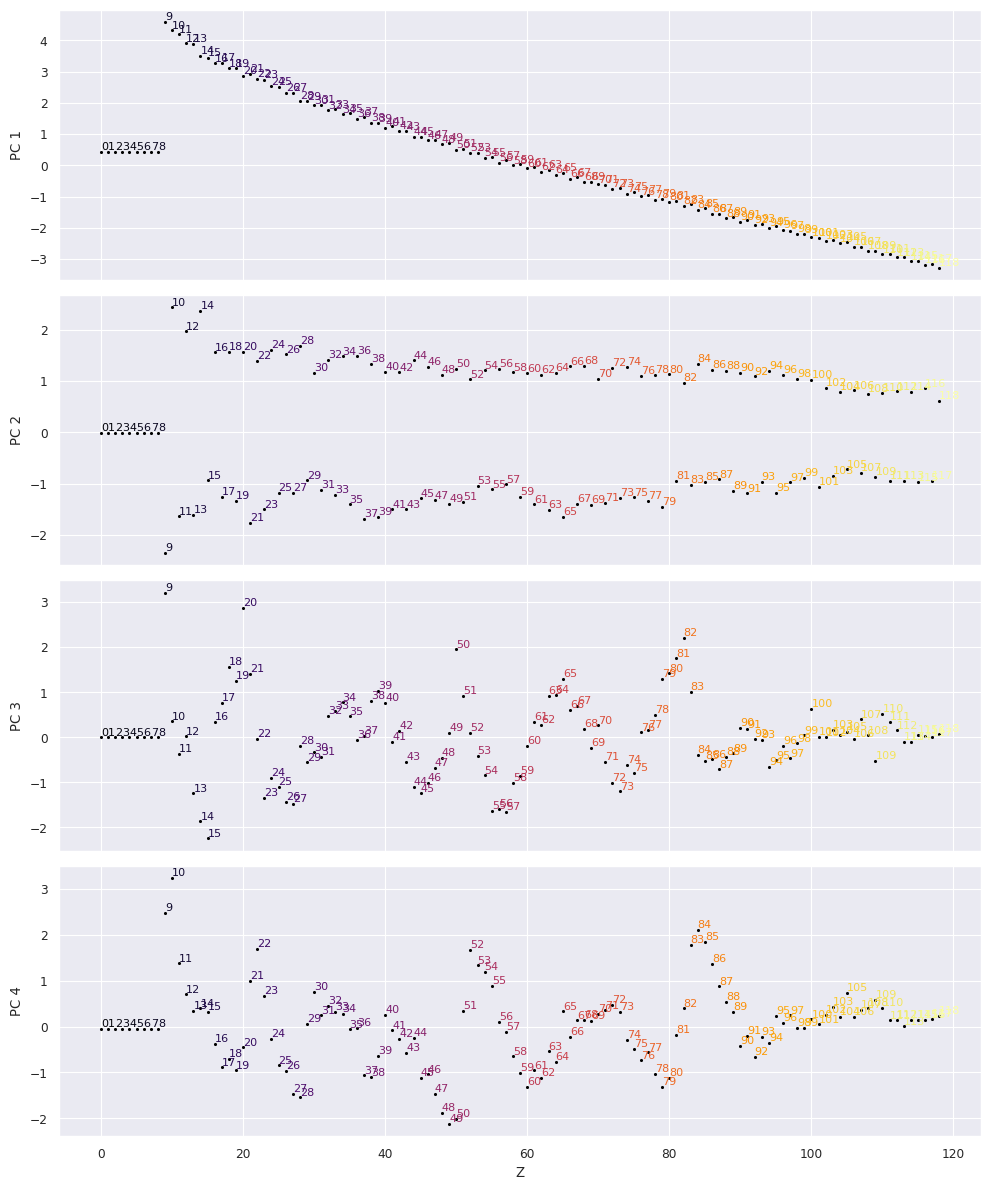

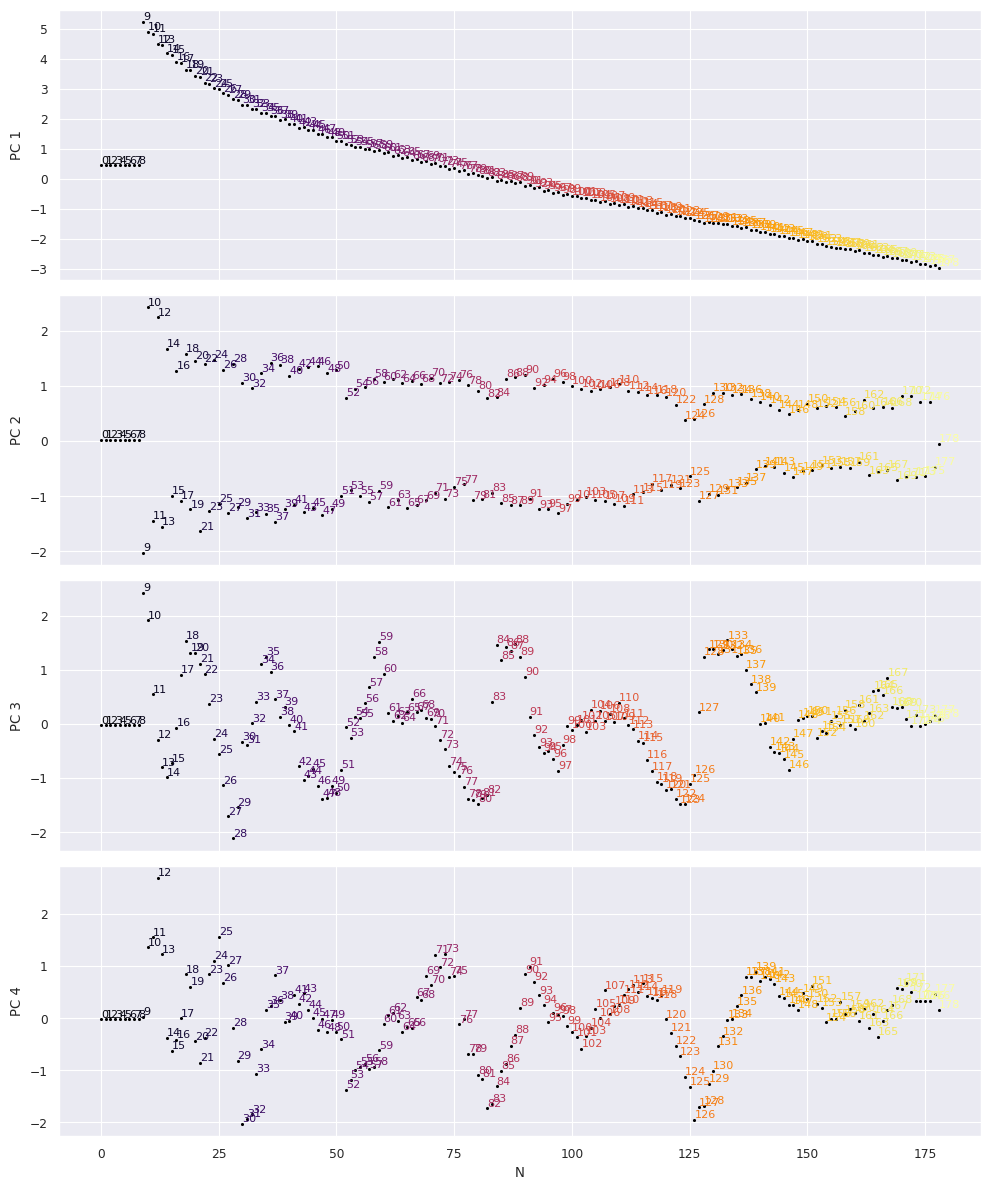

In [13]:
# let's take a look at our embeddings
for i, nucleon in enumerate(["Z", "N"]):
    embed = new_model.emb[i].detach().cpu().numpy()

    pca = PCA(n_components=(n_components:=4))
    # pca = Isomap(n_components=(n_components:=4))
    embed = pca.fit_transform(embed)
    colors = plt.cm.inferno(np.linspace(0, 1, len(embed)))

    fig, axes = plt.subplots(n_components, 1, figsize=(10, n_components*3), sharex=True)
    axes = axes.flatten()
    for i in range(0, n_components):
        ax = axes[i]
        x, y = np.arange(len(embed)), embed[:, i]
        ax.scatter(x, y, s=2, c='k')
        PlottingContext.scatter_text(np.arange(len(embed)), x, y, colors=colors, ax=ax, fontsize=8)
        ax.set_ylabel(f"PC {i+1}")

    ax.set_xlabel(nucleon)
    fig.tight_layout()
    # plt.savefig(f"plots/paper/new_{model_name}_embeddings_{nucleon}.pdf")
    plt.show()

In [14]:
device = "cpu"
X_train = data.X[~torch.isnan(data.y).view(-1)]
y_train = data.y[~torch.isnan(data.y).view(-1)]

X_train, y_train = X_train[X_train[:, 2] == 0],  y_train[X_train[:, 2] == 0]

# Save the last layer activations
acts = torch.zeros(len(X_train), 2048, device=device)
# save the activations fed into the readout layer
hook = new_model.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
new_model(X_train)
hook.remove()

def inverse_transform(vector, index):
    """inverse transform the vector to the original scale"""
    scale = data.regression_transformer.data_max_[index] - data.regression_transformer.data_min_[index]
    min_ = data.regression_transformer.data_min_[index]
    vector = vector * scale + min_
    return vector

# Ensure that the RMS is the same as the franken model
def get_preds_from_last_acts(acts):
    preds = new_model.readout(acts) 
    preds = preds.detach().cpu().numpy()
    preds = data.regression_transformer.inverse_transform(preds)
    return preds[:, 0]

def get_rms_from_last_acts(acts):
    preds = get_preds_from_last_acts(acts)
    targets = y_train.detach().cpu().numpy().reshape(-1)
    # targets = inverse_transform(targets, 0)
    zn = X_train[:, :2].detach().cpu().numpy()
    rms = get_rms(preds, targets, zn, scale_by_A=args.PER_NUCLEON=="true")
    return rms
print(f"RMS recomputed: {get_rms_from_last_acts(acts):.2f}")

RMS recomputed: 26.00


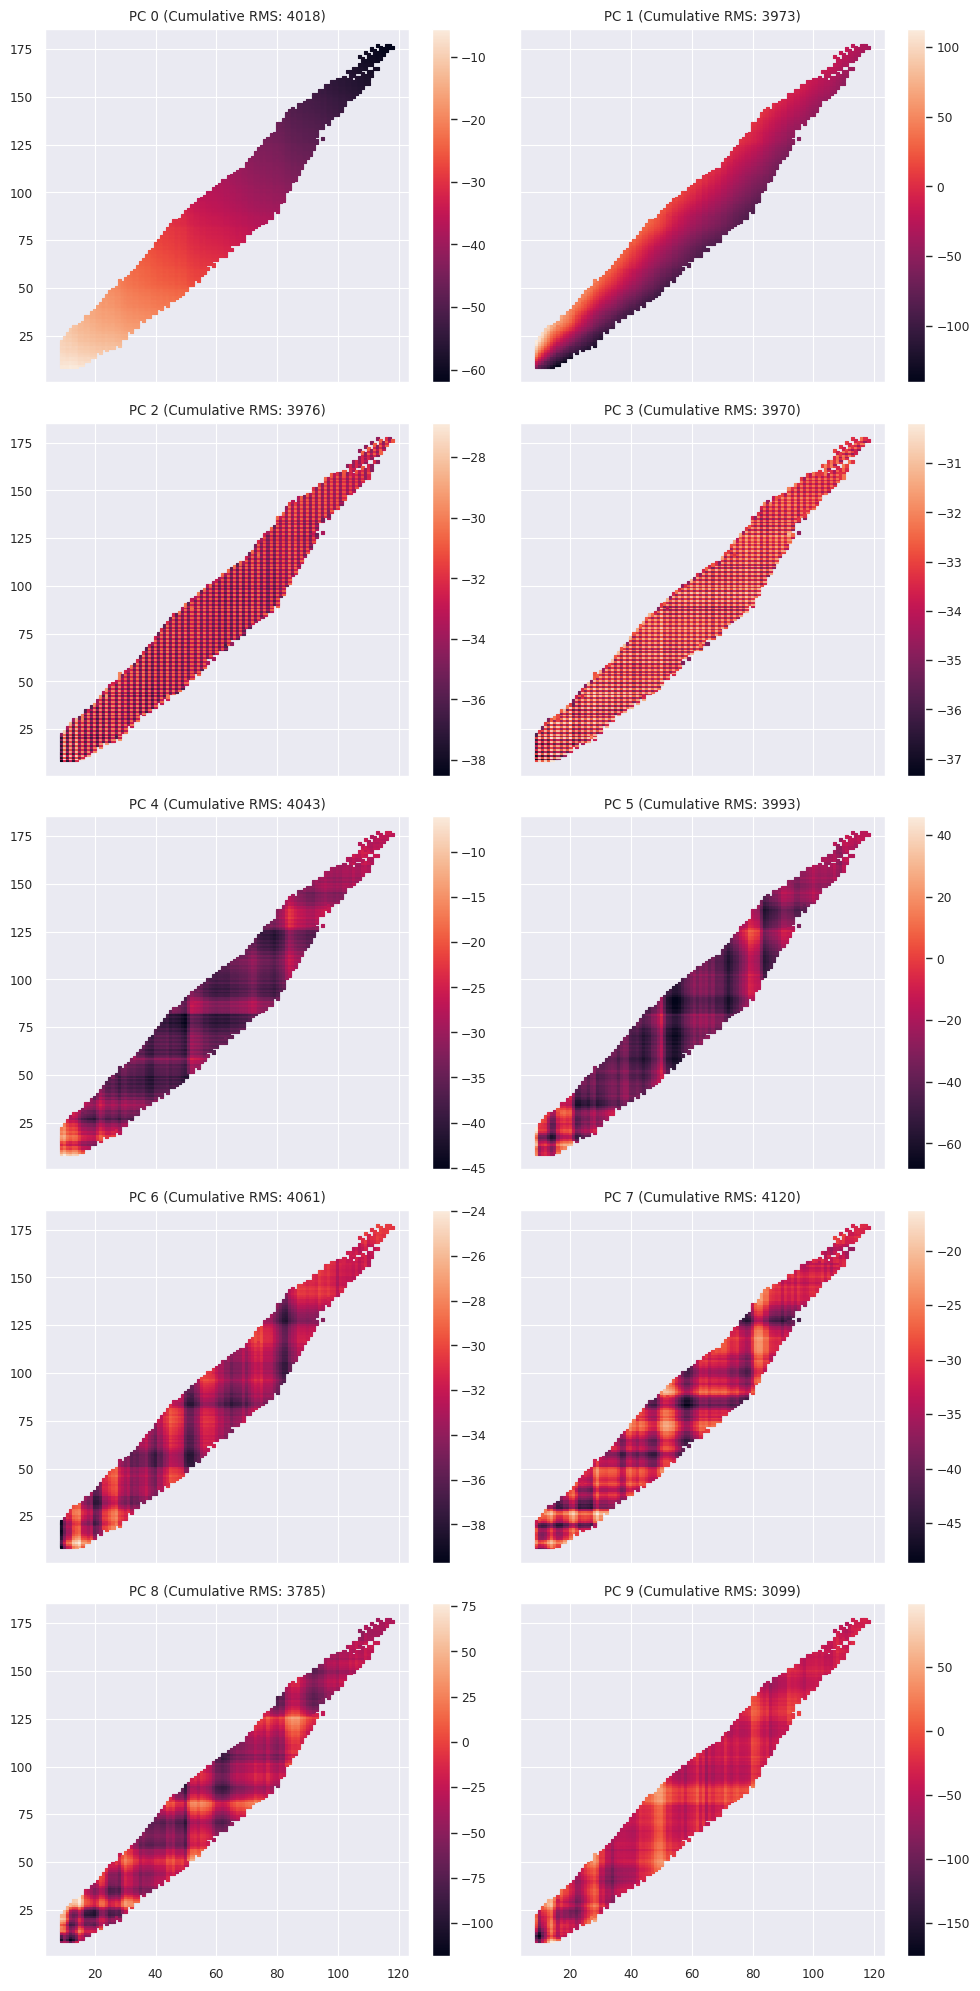

In [15]:
pca = PCA(n_components=100)
# pca = FastICA(n_components=100, fun=lambda x: (x, np.ones(1)))
acts_pca = pca.fit_transform(acts.cpu().numpy(), y_train.detach().cpu().numpy().flatten())
# let's visualize all the PCs as a function of input
num_plots = min(acts_pca.shape[1], 10)
fig, axes = plt.subplots(max(num_plots//2, 1), 2, figsize=(10, 2 * num_plots), sharex=True, sharey=True)
axes = axes.flatten()
Z, N = X_train[:, 0].detach().cpu().numpy(), X_train[:, 1].detach().cpu().numpy()
scale = data.regression_transformer.data_max_ - data.regression_transformer.data_min_
min_ = data.regression_transformer.data_min_

features = []
for i in range(num_plots):
    # get rms for the current PC
    acts_pca_ = acts_pca.copy()
    acts_pca_[:, i+1:] = 0
    acts_pca_cumulative = pca.inverse_transform(acts_pca_)
    acts_pca_cumulative = torch.tensor(acts_pca_cumulative, device=device, dtype=torch.float32)
    rms = get_rms_from_last_acts(acts_pca_cumulative)
    # plot
    ax = axes.flatten()[i]
    acts_pca_[:, :i] = 0
    acts_pca_singular = pca.inverse_transform(acts_pca_)
    acts_pca_singular = torch.tensor(acts_pca_singular, device=device, dtype=torch.float32)
    color = new_model.readout(acts_pca_singular).detach().cpu().numpy()
    color = (color * scale + min_)[:, 0]
    # color = get_preds_from_last_acts(acts_pca_singular)
    features.append(color)
    sc = ax.scatter(Z, N, c=color, s=5, marker='s')
    ax.set_title(f"PC {i} (Cumulative RMS: {rms:.0f})")
    fig.colorbar(sc, ax=ax)
fig.tight_layout()
# fig.savefig(f"plots/paper/{model_name}_features.pdf")

In [8]:
from lib.utils import Physics

terms = [getattr(Physics, func) for func in Physics.all_funcs]

/work/submit/kitouni/code/NuCLR-MechInterp/lib/utils.py:218: RuntimeWarning: invalid value encountered in divide
  P = nup * nun / (nup + nun)


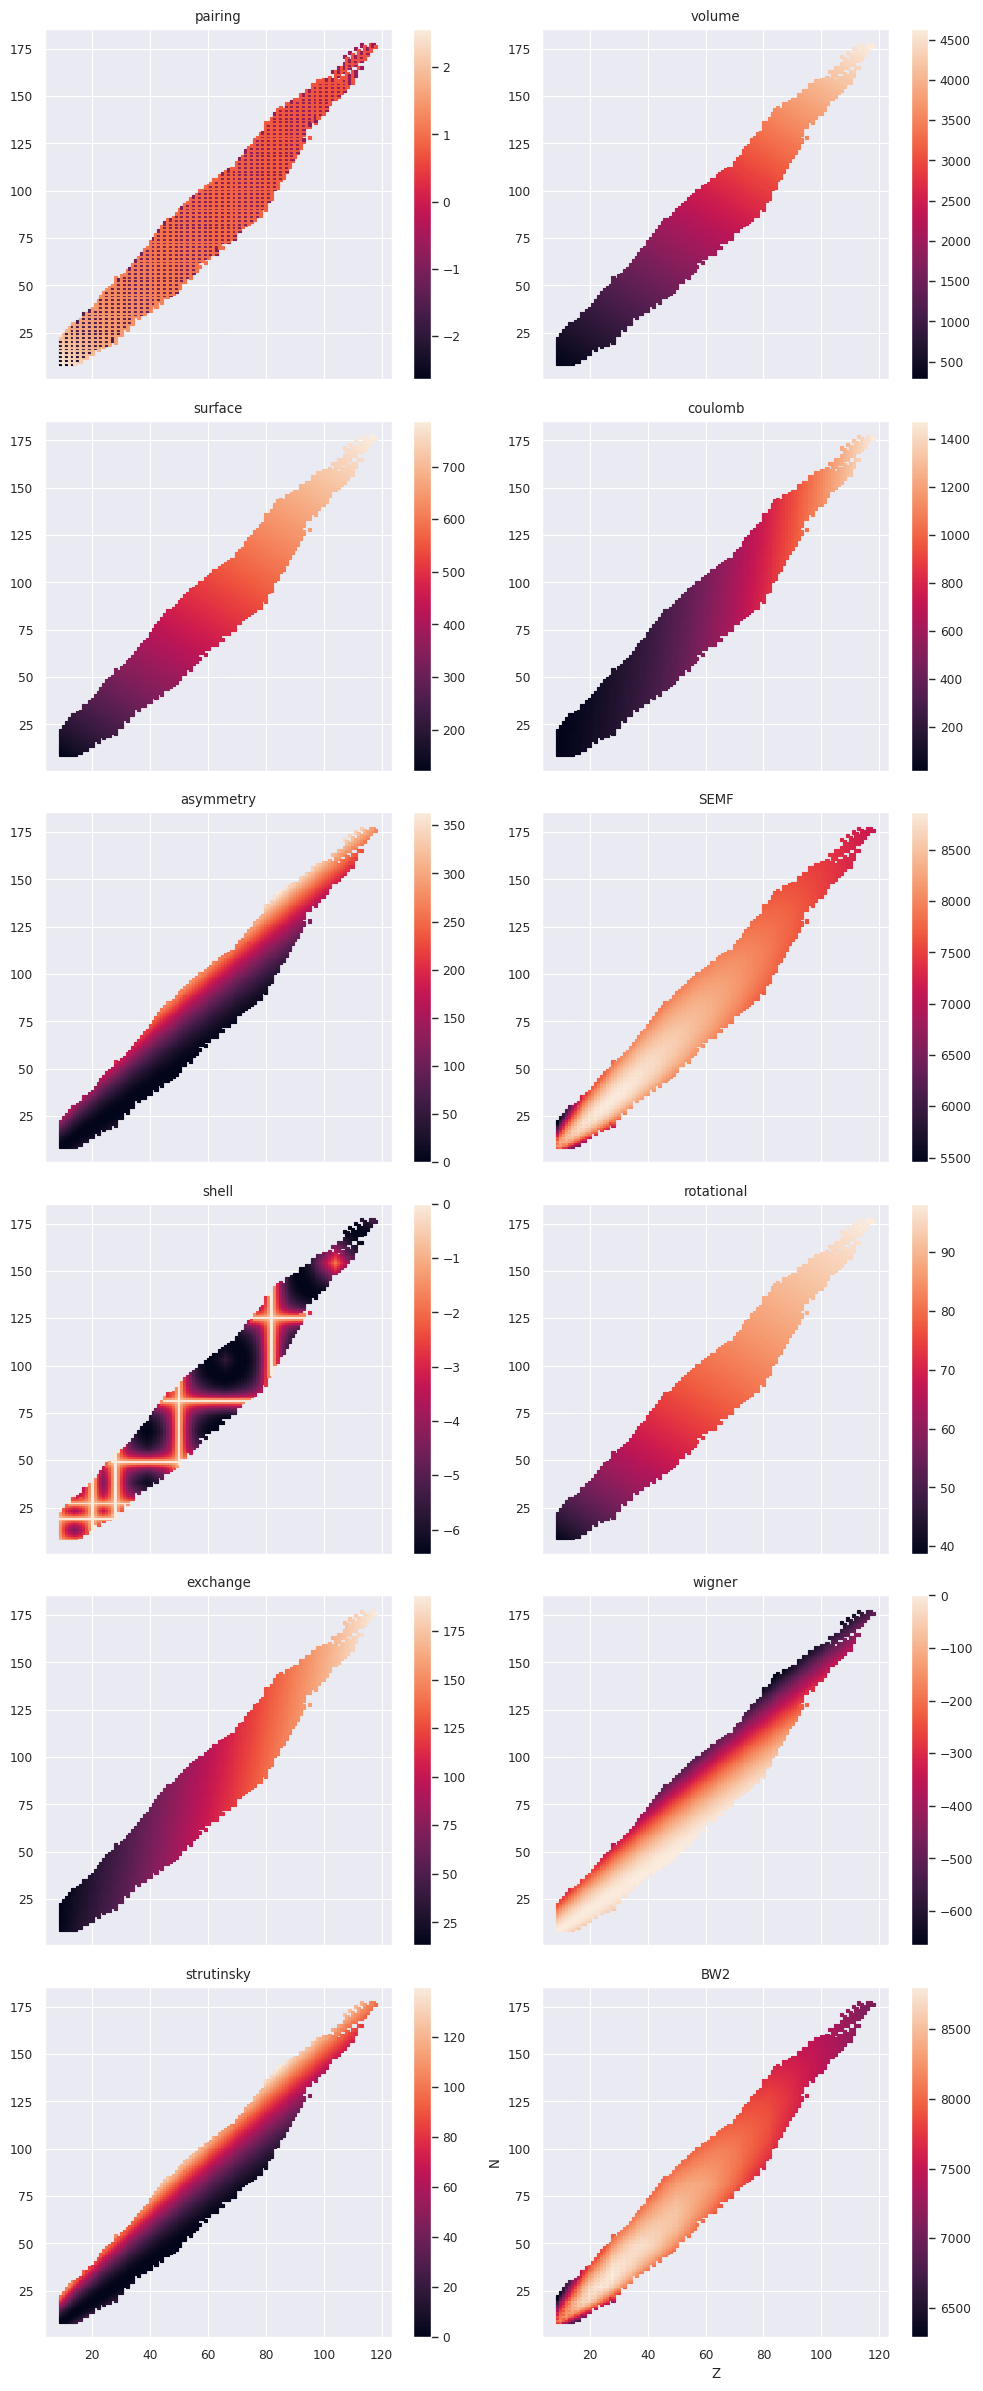

In [9]:
fig, axes = plt.subplots(len(terms)//2, 2, figsize=(10, 2 * len(terms)), sharex=True)
for i, term in enumerate(terms):
    ax = axes.flatten()[i]
    # xi = np.linspace(Z.min(), Z.max(), 200)
    # yi = np.linspace(N.min(), N.max(), 200)
    # xi, yi = np.meshgrid(xi, yi)
    # zi = griddata((Z, N), term(Z, N), (xi, yi), method='linear')
    # ax.imshow(zi, extent=(Z.min(), Z.max(), N.min(), N.max()), origin='lower', aspect='auto')
    sc = ax.scatter(Z, N, c=term(Z, N), s=5, marker='s')
    ax.set_title(term.__name__)
    fig.colorbar(sc, ax=ax)
ax.set_xlabel("Z")
ax.set_ylabel("N")
plt.tight_layout()
# plt.savefig(f"plots/paper/physics_terms.pdf")
plt.show()


In [20]:
pca = PCA(n_components=100)
acts_pca = pca.fit_transform(acts.cpu().numpy(), y_train.detach().cpu().numpy().flatten())
# now we compute individual PCs contribution to the final prediction
new_features = []

for i in range(acts_pca.shape[1]):
    # get rms for the current PC
    acts_pca_ = acts_pca.copy()
    acts_pca_[:, i+1:] = 0
    acts_pca_[:, :i] = 0
    acts_pca_singular = pca.inverse_transform(acts_pca_)
    acts_pca_singular = torch.tensor(acts_pca_singular, device=device, dtype=torch.float32)
    feature = get_preds_from_last_acts(acts_pca_singular)
    new_features.append(feature)


In [37]:
import os
X = np.array(new_features)
y = [term(Z, N) for term in terms]
y = np.array(y)
os.makedirs("features", exist_ok=True)
np.save(f"features/{model_name}_features.npy", X)
np.save(f"features/physics_terms.npy", y)
np.save(f"features/zn.npy", np.array([Z, N]).T)
true_values = y_train.detach().cpu().numpy().reshape(-1) + semi_empirical_mass_formula(Z, N)
np.save(f"features/BE.npy", true_values)

/work/submit/kitouni/code/NuCLR-MechInterp/lib/utils.py:218: RuntimeWarning: invalid value encountered in divide
  P = nup * nun / (nup + nun)


/work/submit/kitouni/code/NuCLR-MechInterp/lib/utils.py:208: RuntimeWarning: invalid value encountered in divide
  nup = np.array([abs(x - find_nearest(magic, x)) for x in Z])


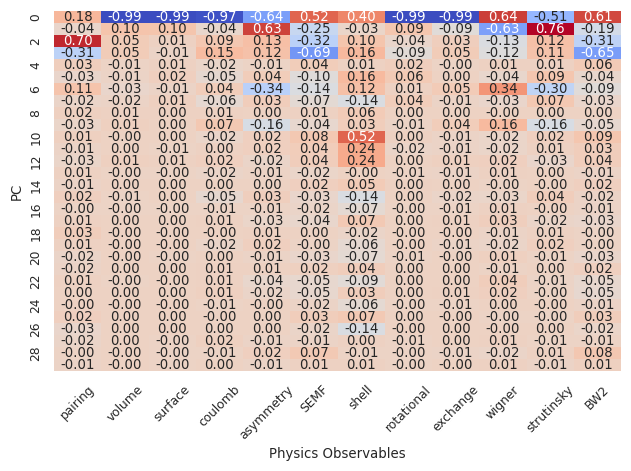

In [22]:
# center and unit norm features
X = np.array(new_features[:30]).T
X = X - X.mean(axis=0)
X = X / np.linalg.norm(X, axis=0)
y = [term(Z, N) for term in terms]
y = np.array(y).T
y = y - y.mean(axis=0)
y = y / np.linalg.norm(y, axis=0)
# correlation matrix
corr = np.corrcoef(X.T, y.T)
# only care about x y covariance
corr = corr[:X.shape[1], -y.shape[1]:]
# plot
fig, ax = plt.subplots()
sns.heatmap(corr, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
ax.set_xticklabels([term.__name__ for term in terms], rotation=45)
ax.set_xlabel("Physics Observables")
ax.set_ylabel("PC")
plt.tight_layout()


# plt.savefig(f"plots/paper/{model_name}_correlation_matrix.pdf")

/work/submit/kitouni/code/NuCLR-MechInterp/lib/utils.py:210: RuntimeWarning: invalid value encountered in divide
  P = nup * nun / (nup + nun)


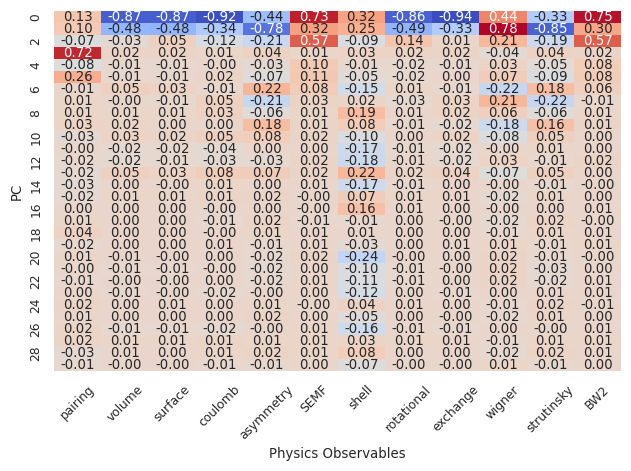

In [ ]:
# center and unit norm features
X = np.array(new_features[:30]).T
X = X - X.mean(axis=0)
X = X / np.linalg.norm(X, axis=0)
y = [term(Z, N) for term in terms]
y = np.array(y).T
y = y - y.mean(axis=0)
y = y / np.linalg.norm(y, axis=0)
# correlation matrix
corr = np.corrcoef(X.T, y.T)
# only care about x y covariance
corr = corr[:X.shape[1], -y.shape[1]:]
# plot
fig, ax = plt.subplots()
sns.heatmap(corr, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
ax.set_xticklabels([term.__name__ for term in terms], rotation=45)
ax.set_xlabel("Physics Observables")
ax.set_ylabel("PC")
plt.tight_layout()


# plt.savefig(f"plots/paper/{model_name}_correlation_matrix.pdf")

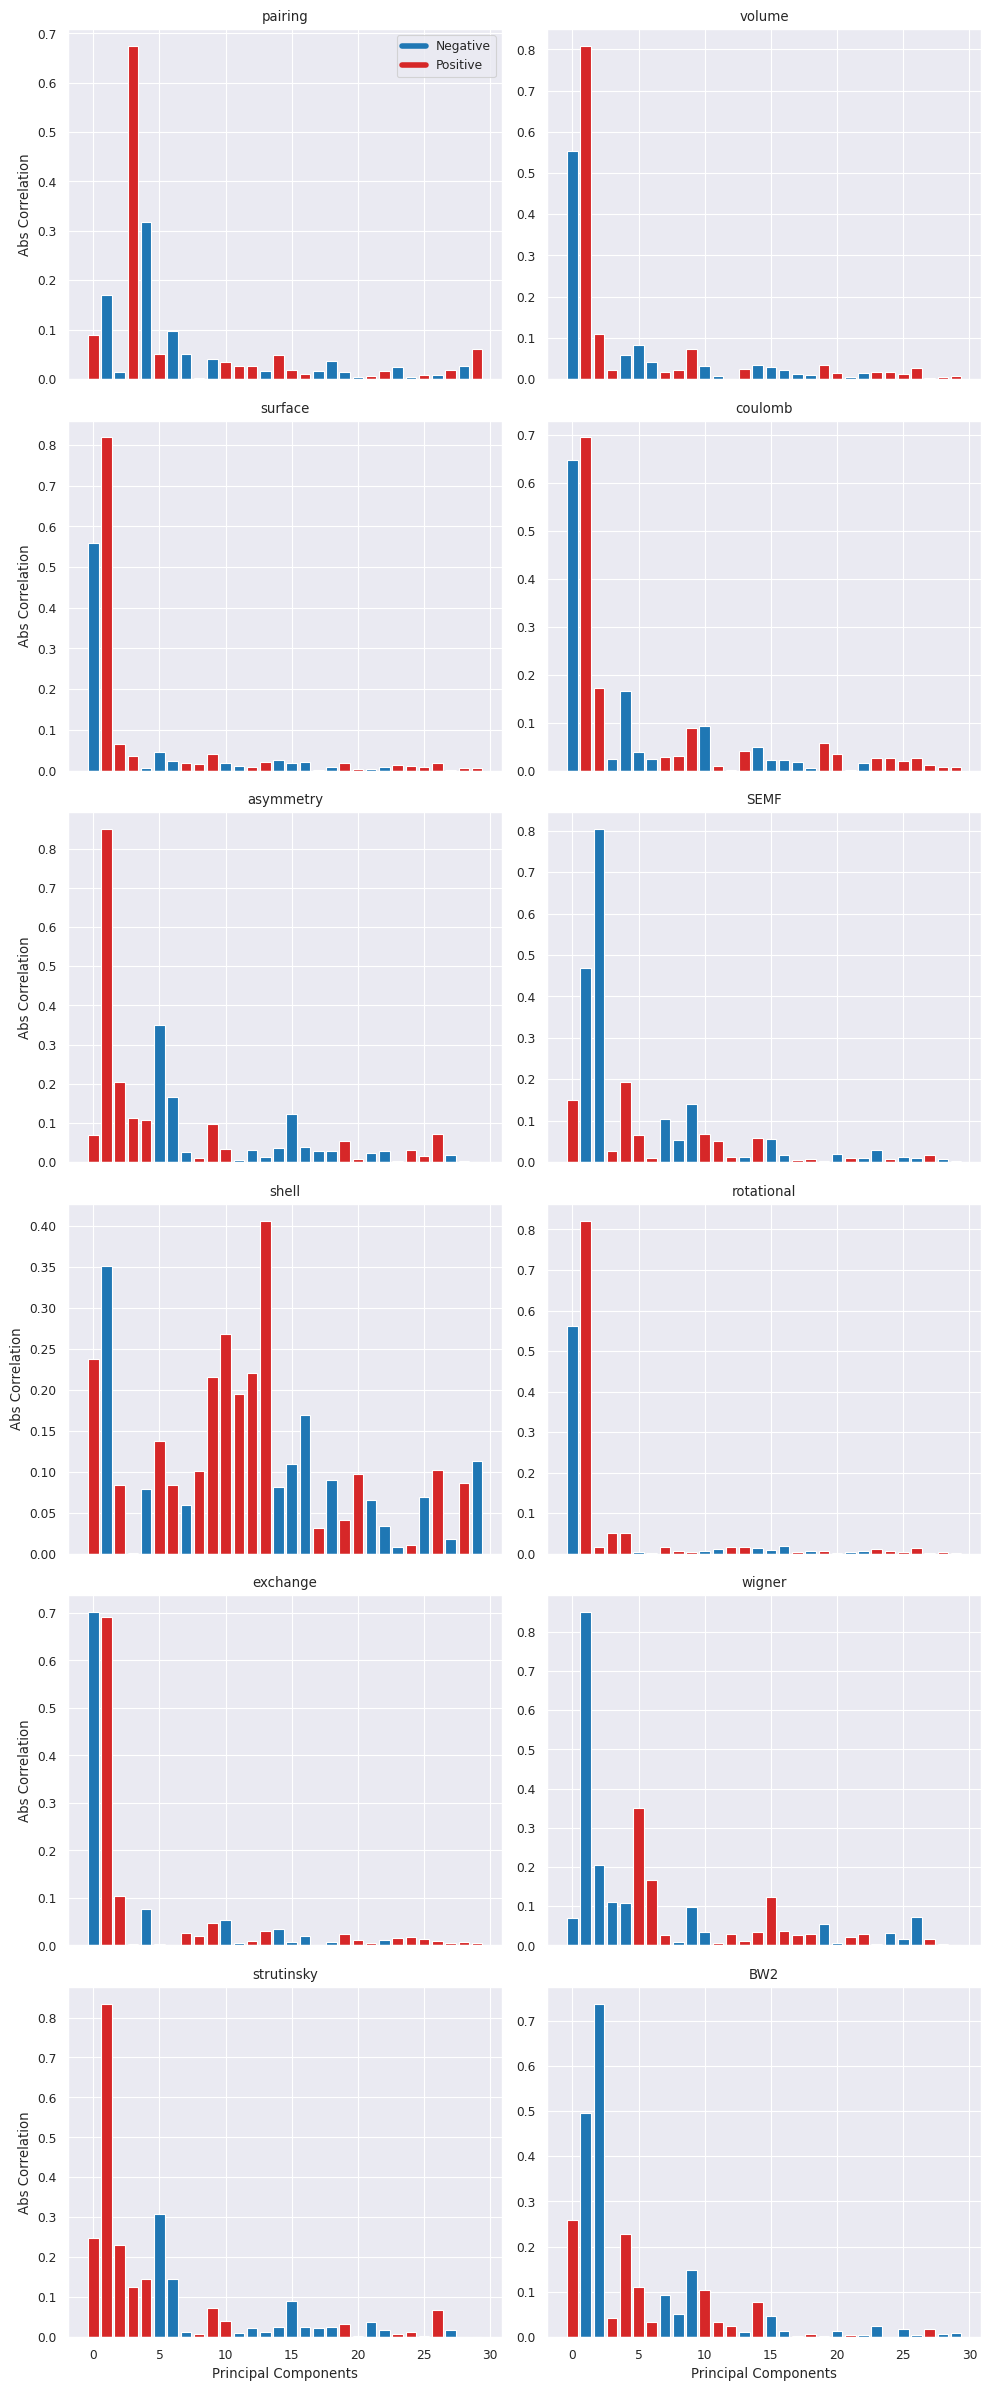

In [40]:
fig, axes = plt.subplots(len(terms)//2, 2, figsize=(10, 2 * len(terms)), sharex=True)
for i, term in enumerate(terms):
    ax = axes.flatten()[i]
    ax.bar(np.arange(len(corr)), np.abs(corr[:, i]), color=['C0' if c < 0 else 'C3' for c in corr[:, i]])
    ax.set_title(term.__name__)
    if i % 2 == 0:
        ax.set_ylabel("Abs Correlation")
ax = axes.flatten()[-2]
ax.set_xlabel("Principal Components")
axes.flatten()[-1].set_xlabel("Principal Components")
# add legend for the colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='Negative'),
                   Line2D([0], [0], color='C3', lw=4, label='Positive')]
axes[0, 0].legend(handles=legend_elements, loc='upper right')
############
plt.tight_layout()
fig.savefig(f"plots/paper/{model_name}_correlation.pdf")

In [65]:
# print most important features given the correlation matrix
for i, term in enumerate(terms):
    print(term.__name__, *map(lambda x: f"PC{x}", np.argsort(np.abs(corr[:, i]))[::-1][:5]))


pairing PC3 PC5 PC0 PC4 PC1
volume PC0 PC1 PC13 PC6 PC10
surface PC0 PC1 PC2 PC6 PC13
coulomb PC0 PC1 PC2 PC13 PC10
asymmetry PC1 PC0 PC6 PC2 PC7
semi_empirical_mass_formula PC0 PC2 PC1 PC5 PC4


pairing RMSE: 1.02 +/- 0.51


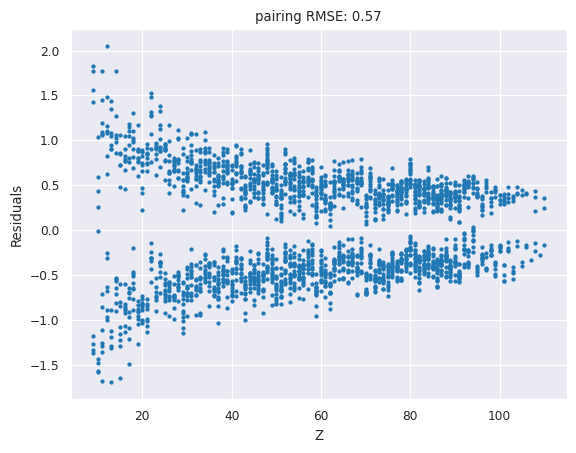

In [ ]:
# linear regression on the features to each term in the SEMF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
X = np.array(new_features).T

for i, term in enumerate(terms):
    lr = LinearRegression()
    scores = cross_val_score(lr, X, term(Z, N), cv=5, scoring='neg_root_mean_squared_error')
    print(f"{term.__name__} RMSE: {-scores.mean():.2f} +/- {scores.std():.2f}")

    lr.fit(X, term(Z, N))
    # print(lr.coef_)

    fig, ax = plt.subplots()
    # show residuals
    ax.scatter(Z, term(Z, N) - lr.predict(X), s=5)

    ax.set_xlabel("Z")
    ax.set_ylabel("Residuals")
    ax.set_title(f"{term.__name__} RMSE: {mean_squared_error(term(Z, N), lr.predict(X), squared=False):.2f}")
    # plt.savefig(f"plots/paper/{model_name}_{term.__name__}_regression.pdf")
    plt.show()
    break

Top 5 features for pairing: PC3 (0.78) PC0 (0.05) PC5 (0.05) PC2 (0.04) PC4 (0.03)


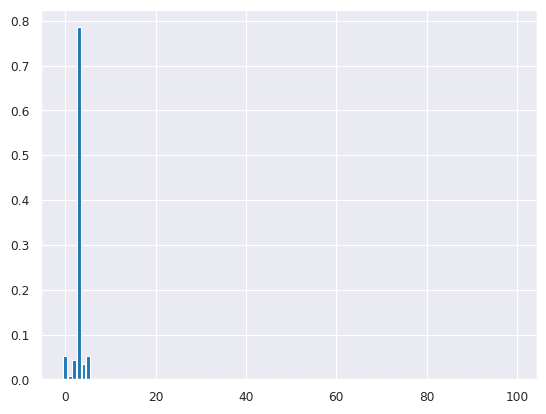

Top 5 features for volume: PC0 (0.64) PC2 (0.26) PC1 (0.06) PC13 (0.02) PC9 (0.00)


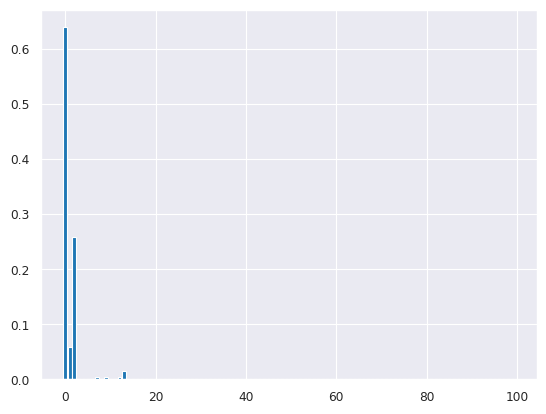

Top 5 features for surface: PC0 (0.63) PC2 (0.27) PC1 (0.06) PC13 (0.01) PC9 (0.00)


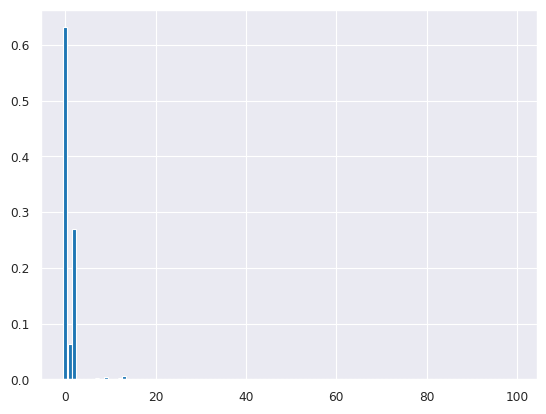

Top 5 features for coulomb: PC0 (0.76) PC2 (0.17) PC1 (0.04) PC13 (0.02) PC7 (0.00)


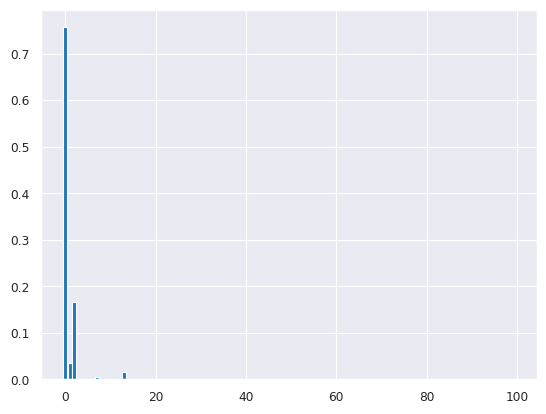

Top 5 features for asymmetry: PC1 (0.74) PC0 (0.20) PC2 (0.04) PC10 (0.01) PC13 (0.00)


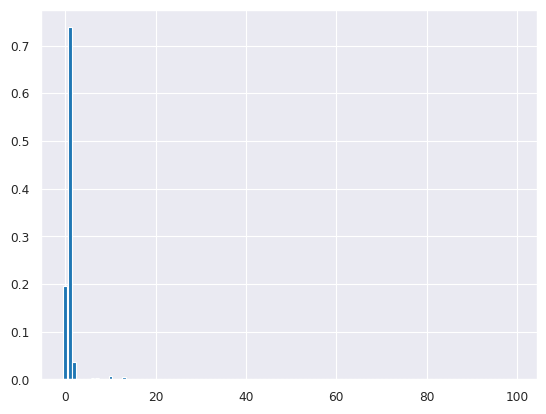

Top 5 features for semi_empirical_mass_formula: PC0 (0.64) PC2 (0.20) PC1 (0.10) PC13 (0.03) PC10 (0.01)


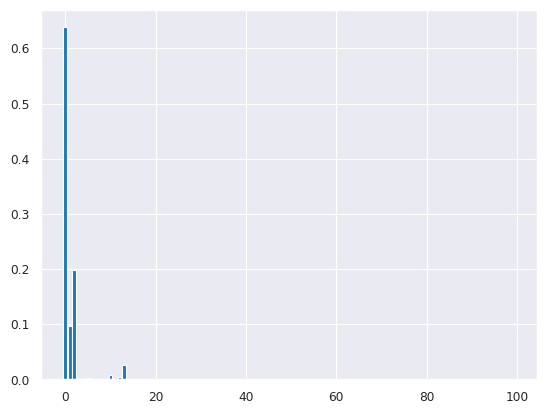

In [64]:
# obtain feature importance
from sklearn.ensemble import RandomForestRegressor
for i, term in enumerate(terms):
    rf = RandomForestRegressor()
    rf.fit(X, term(Z, N))
    importance = rf.feature_importances_
    # top 5 features
    indices = np.argsort(importance)[::-1]
    print(f"Top 5 features for {term.__name__}:", * [f"PC{index} ({importance[index]:.2f})" for i, index in enumerate(indices[:5])])
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
